In [127]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS, DBSCAN, cluster_optics_dbscan
from sklearn_extra.cluster import KMedoids
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from sklearn.base import clone
import yfinance as yf
from utils.utils import Portfolio
from utils.helpers import pooled_within_ssd, gen_realizations, gap_statistic, cluster_range, plot_internal, plot_internal_zoom_range, generate_date_combinations
from utils.clusters import kmeans_cluster, kmedoids_cluster, agglomerative_cluster
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers = 6)
from tqdm import tqdm

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Load Data from YF for S&P500 and save it

In [129]:
sp500 = Portfolio('2013-01-01', '2024-01-01')
dji = Portfolio('2012-01-01','2024-01-01', file = 'data/dji.csv')
gspc = Portfolio('2012-01-01','2024-01-01', file = 'data/gspc.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/sp500_data.csv'

### KMeans (3:1)

In [105]:
avg3s_portfolio = Portfolio('2016-01-01', '2024-01-01', tickers = eval(avg3s[avg3s['Start'] == '2018-01-04']['portfolio'].values[0]))
avg3s_portfolio

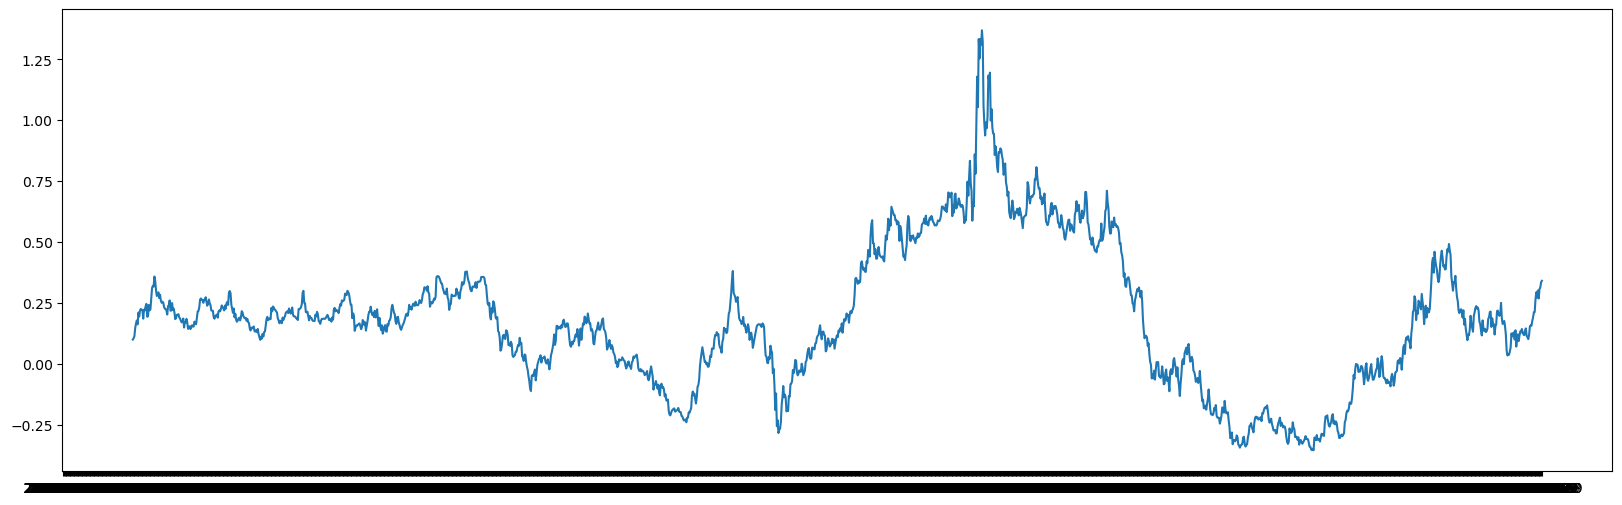

In [122]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(pd.DataFrame(avg3s_portfolio.prices.sum(axis = 1).pct_change(periods = 252)))
plt.show()

In [26]:
avg3s = pd.read_csv('data/avg_scaled_3-1.csv')
avg3s['rank'] = avg3s.groupby('Sell')['sharpe'].rank(method='max', ascending=False)
avg3s = avg3s[avg3s['rank'] == 1].drop(['rank'], axis = 1)

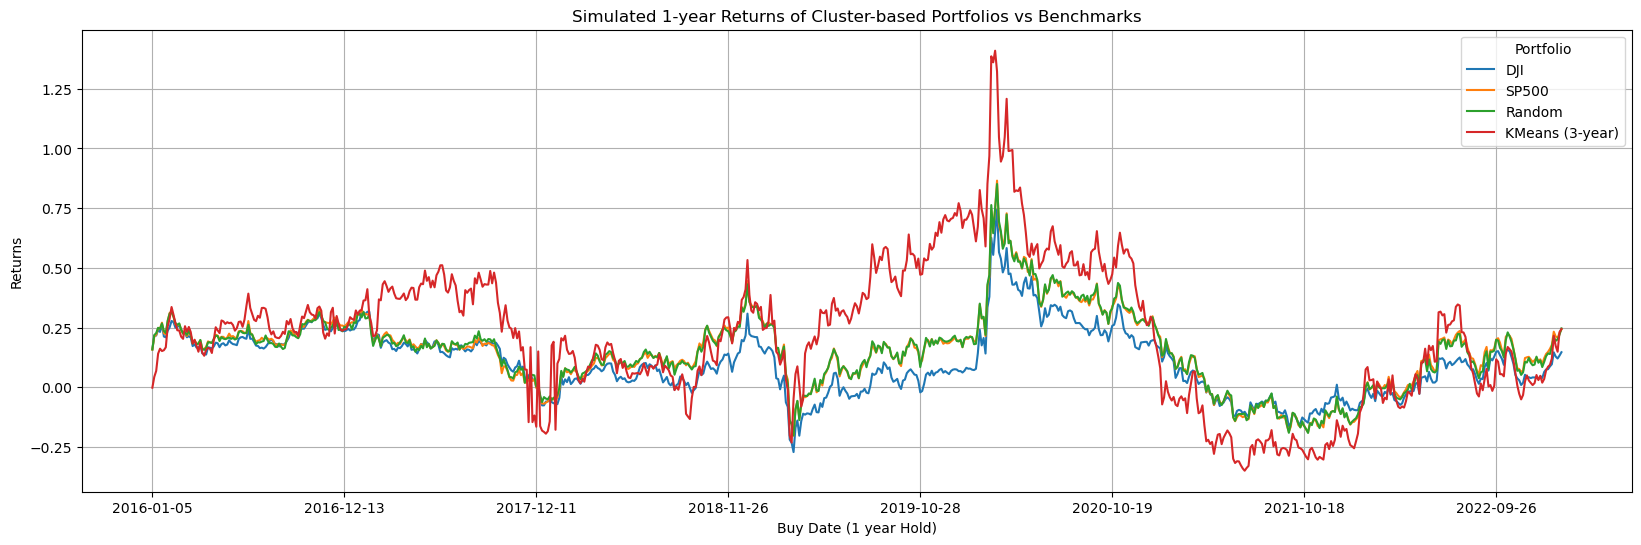

In [27]:
avg3s_returns = avg3s[['Buy', 'DJI_Return', 'SP500_Return', 'Random_Return', 'return']]
avg3s_returns.columns = ['Buy Date', 'DJI', 'SP500', 'Random', 'KMeans (3-year)']
avg3s_returns = avg3s_returns.set_index('Buy Date')
fig, ax = plt.subplots(figsize=(20, 6))

avg3s_returns.plot(ax=ax)

ax.set_title('Simulated 1-year Returns of Cluster-based Portfolios vs Benchmarks')
ax.set_xlabel('Buy Date (1 year Hold)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

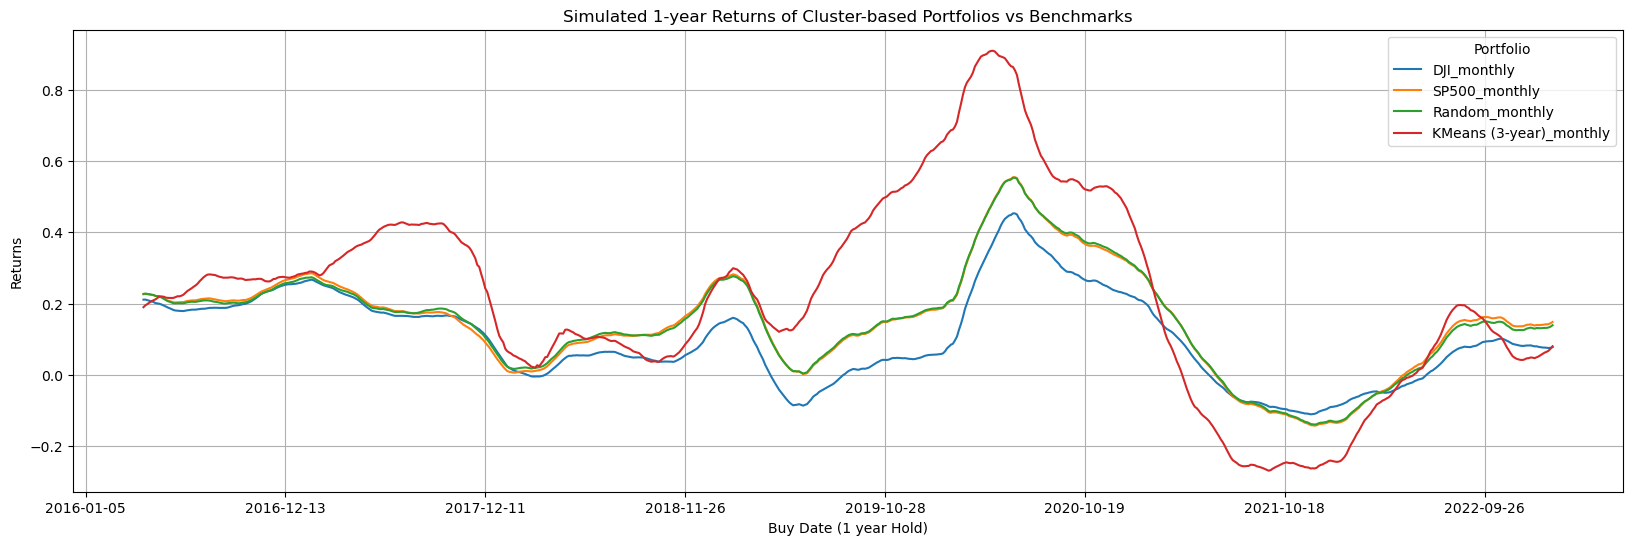

In [30]:
cols = ['DJI', 'SP500', 'Random', 'KMeans (3-year)']
cols_monthly = []
for k in cols:
    colname = f"{k}_monthly"
    avg3s_returns[colname] = avg3s_returns[k].rolling(window=30).mean()
    cols_monthly.append(colname)

fig, ax = plt.subplots(figsize=(20, 6))


avg3s_returns[cols_monthly].plot(ax=ax)

ax.set_title('Simulated 1-year Returns of Cluster-based Portfolios vs Benchmarks')
ax.set_xlabel('Buy Date (1 year Hold)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

,DJI,SP500,Random,KMeans (3-year)
Buy Date,,,,
2016-12-27,0.242128,0.270219,0.271987,0.281988
2017-12-26,-0.075477,-0.068216,-0.040909,-0.186718
2018-12-31,0.223384,0.358626,0.357468,0.387377
2019-12-30,0.068421,0.192264,0.198899,0.705359
2020-12-30,0.196929,0.297676,0.293249,0.278006
2021-12-29,-0.089557,-0.146349,-0.143394,-0.247552
2022-12-28,0.147051,0.242006,0.246689,0.244226


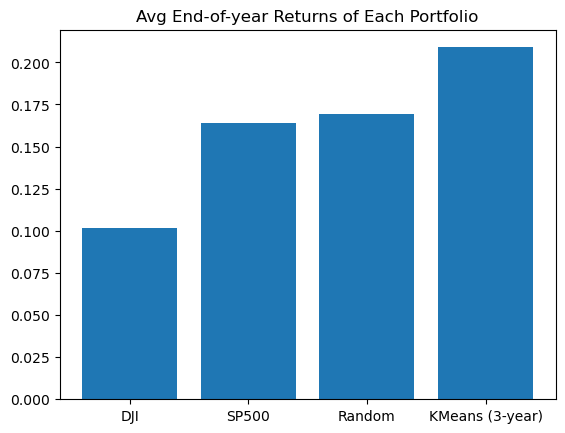

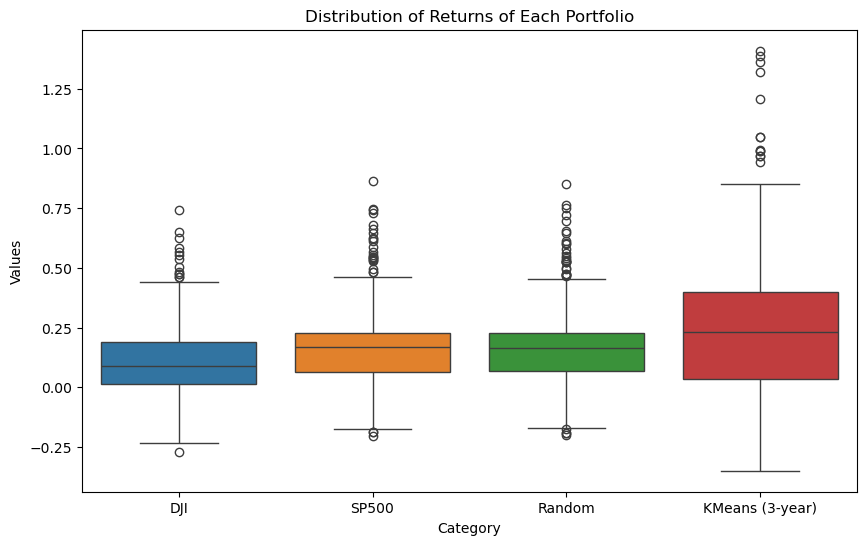

In [36]:
dates = pd.to_datetime(avg3s_returns.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(avg3s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (3-year)']])
plt.bar(['DJI', 'SP500', 'Random', 'KMeans (3-year)'], avg3s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (3-year)']].mean())
plt.title('Avg End-of-year Returns of Each Portfolio')

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create violin plots for each column
sns.boxplot(data=avg3s_returns[['DJI', 'SP500', 'Random', 'KMeans (3-year)']])

# Customize the plot
plt.title('Distribution of Returns of Each Portfolio')
plt.xlabel('Category')
plt.ylabel('Values')
plt.show()

,DJI,SP500,Random,KMeans (3-year)
Buy Date,,,,
2016-12-27,0.206079,0.207164,0.160404,0.109379
2017-12-26,-0.027746,-0.027562,-0.015315,-0.050414
2018-12-31,0.101954,0.158970,0.142023,0.121810
2019-12-30,0.011213,0.030872,0.031362,0.084390
2020-12-30,0.090948,0.120223,0.107729,0.068242
2021-12-29,-0.029849,-0.041302,-0.038702,-0.049139
2022-12-28,0.075951,0.100681,0.089989,0.069348


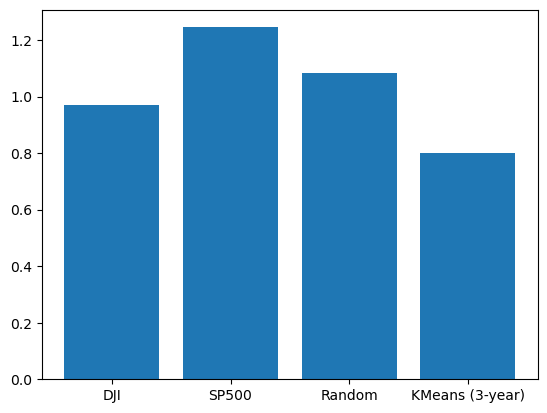

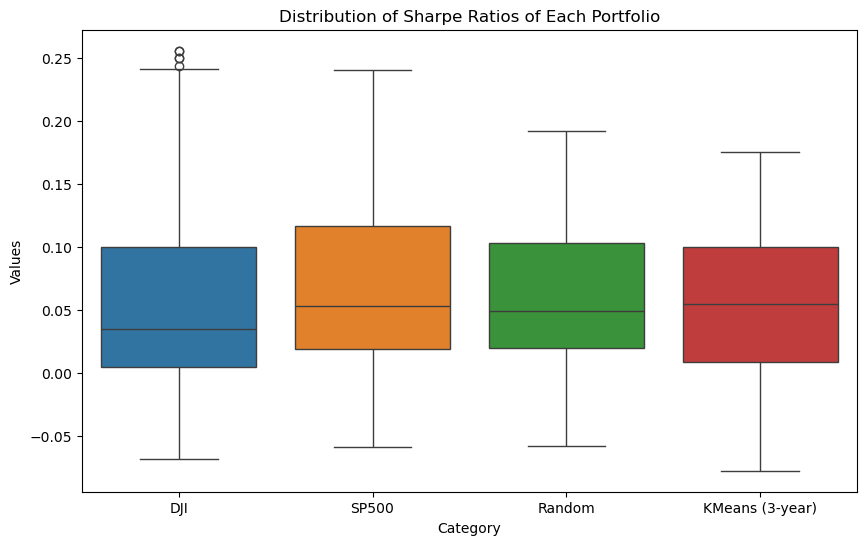

In [49]:
avg3s_sharpe = avg3s[['Buy', 'DJI_Sharpe', 'SP500_Sharpe', 'Random_Sharpe', 'sharpe']]
avg3s_sharpe.columns = ['Buy Date', 'DJI', 'SP500', 'Random', 'KMeans (3-year)']
avg3s_sharpe = avg3s_sharpe.set_index('Buy Date')
dates = pd.to_datetime(avg3s_sharpe.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(avg3s_sharpe.loc[eoy])
plt.bar(avg3s_sharpe.columns, avg3s_sharpe.loc[eoy].mean() * np.sqrt(252))

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create violin plots for each column
sns.boxplot(data=avg3s_sharpe[['DJI', 'SP500', 'Random', 'KMeans (3-year)']])

# Customize the plot
plt.title('Distribution of Sharpe Ratios of Each Portfolio')
plt.xlabel('Category')
plt.ylabel('Values')
plt.show()

,DJI,SP500,Random,KMeans (3-year)
Buy Date,,,,
2016-12-27,0.302871,0.297326,0.246072,0.175379
2017-12-26,-0.034195,-0.034334,-0.019518,-0.071381
2018-12-31,0.123697,0.203784,0.189172,0.176919
2019-12-30,0.012383,0.032883,0.034807,0.086799
2020-12-30,0.125321,0.165878,0.156961,0.093612
2021-12-29,-0.045496,-0.067744,-0.062904,-0.083169
2022-12-28,0.123101,0.158315,0.144556,0.108184


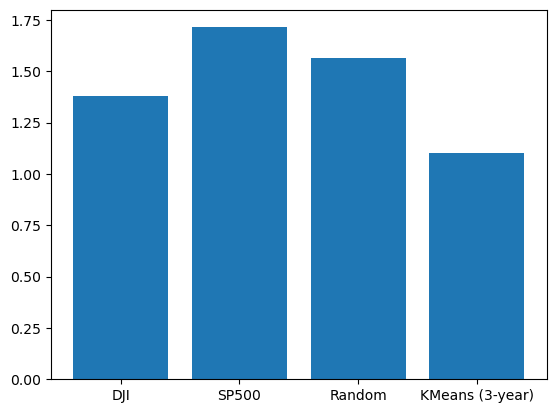

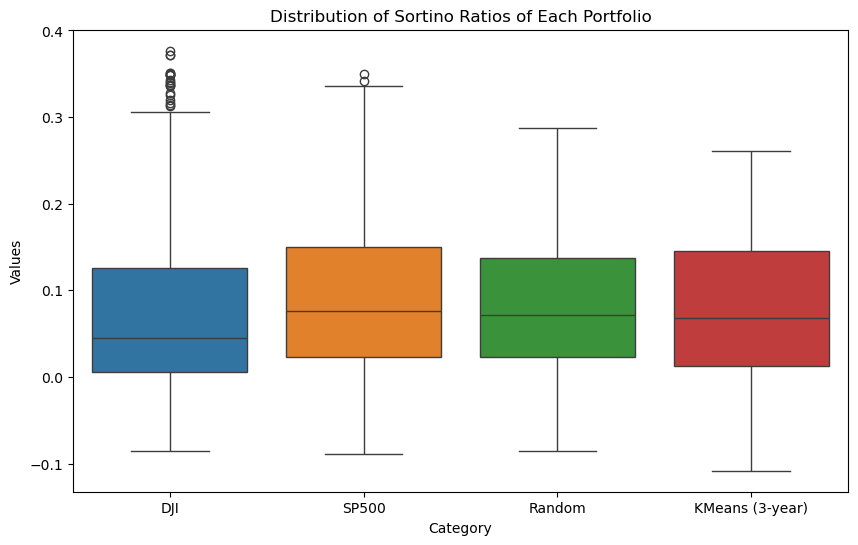

In [46]:
avg3s_sortino = avg3s[['Buy', 'DJI_Sortino', 'SP500_Sortino', 'Random_Sortino', 'sortino']]
avg3s_sortino.columns = ['Buy Date', 'DJI', 'SP500', 'Random', 'KMeans (3-year)']
avg3s_sortino = avg3s_sortino.set_index('Buy Date')
dates = pd.to_datetime(avg3s_sortino.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(avg3s_sortino.loc[eoy])
plt.bar(avg3s_sortino.columns, avg3s_sortino.loc[eoy].mean() * np.sqrt(252))

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create violin plots for each column
sns.boxplot(data=avg3s_sortino[['DJI', 'SP500', 'Random', 'KMeans (3-year)']])

# Customize the plot
plt.title('Distribution of Sortino Ratios of Each Portfolio')
plt.xlabel('Category')
plt.ylabel('Values')
plt.show()

### KMeans (5:1)

In [123]:
avg5s = pd.read_csv('data/avg_scaled_5-1.csv')
avg5s['rank'] = avg5s.groupby('Sell')['sharpe'].rank(method='max', ascending=False)
avg5s = avg5s[avg5s['rank'] == 1].drop(['rank'], axis = 1)

FileNotFoundError: [Errno 2] No such file or directory: 'data/avg_scaled_5-1.csv'

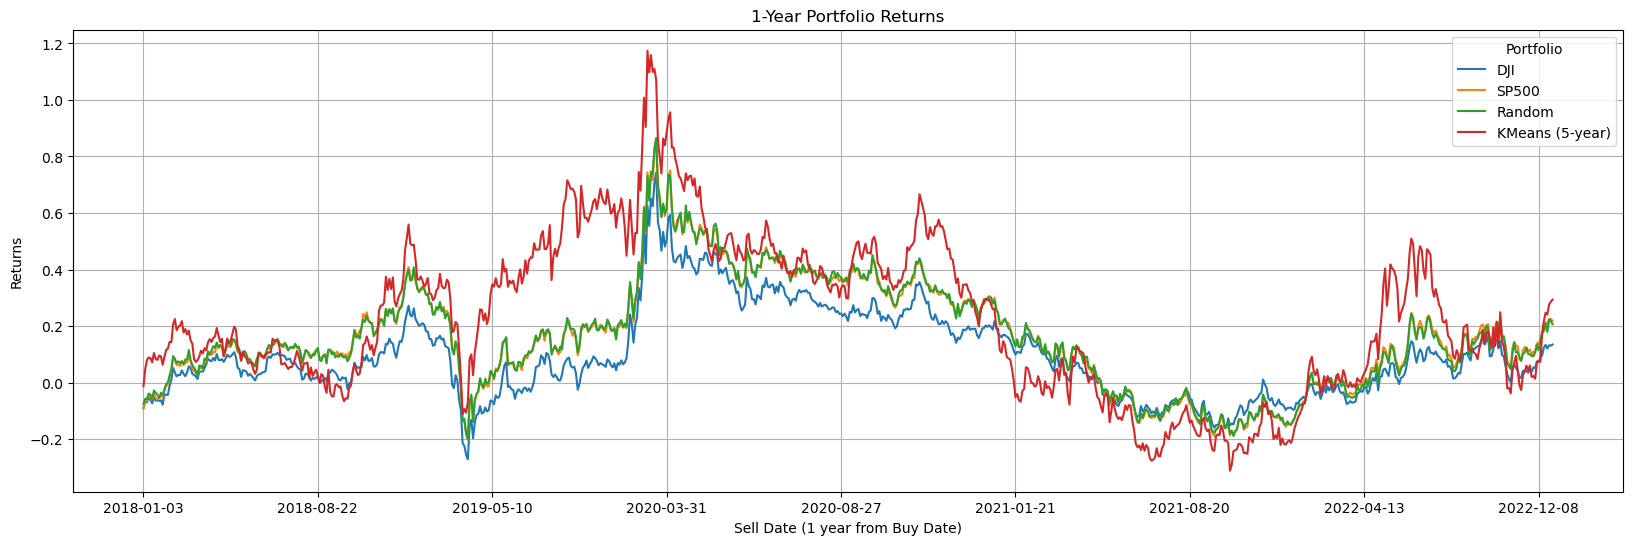

In [54]:
avg5s_returns = avg5s[['Buy', 'DJI_Return', 'SP500_Return', 'Random_Return', 'return']]
avg5s_returns.columns = ['Buy Date', 'DJI', 'SP500', 'Random', 'KMeans (5-year)']
avg5s_returns = avg5s_returns.set_index('Buy Date')
fig, ax = plt.subplots(figsize=(20, 6))

avg5s_returns.plot(ax=ax)

ax.set_title('1-Year Portfolio Returns')
ax.set_xlabel('Sell Date (1 year from Buy Date)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()



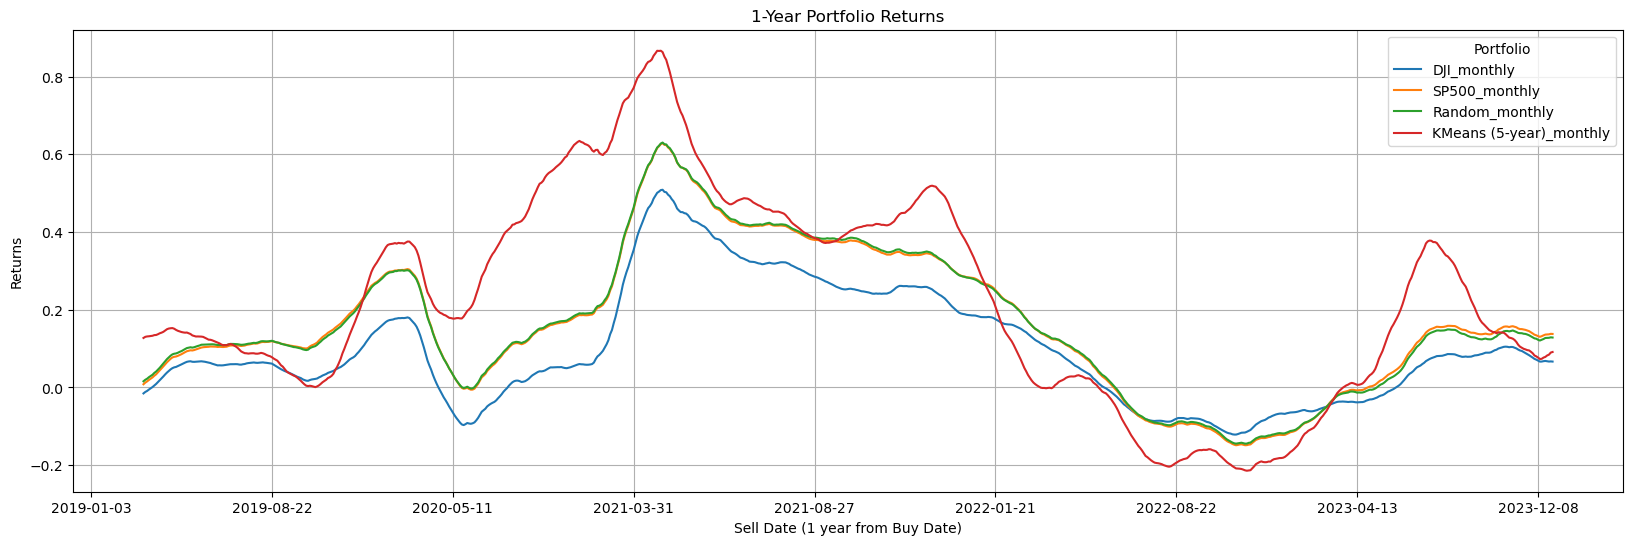

In [12]:
cols = ['DJI', 'SP500', 'Random', 'KMeans (5-year)']
cols_monthly = []
for k in cols:
    colname = f"{k}_monthly"
    kmeans5s_returns[colname] = kmeans5s_returns[k].rolling(window=30).mean()
    cols_monthly.append(colname)

fig, ax = plt.subplots(figsize=(20, 6))


kmeans5s_returns[cols_monthly].plot(ax=ax)

ax.set_title('1-Year Portfolio Returns')
ax.set_xlabel('Sell Date (1 year from Buy Date)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

,DJI,SP500,Random,KMeans (5-year)
Sell Date,,,,
2019-12-30,0.234136,0.368342,0.363398,0.485632
2020-12-28,0.061396,0.186155,0.187064,0.636721
2021-12-31,0.187275,0.288420,0.278877,0.258865
2022-12-30,-0.089313,-0.148165,-0.146392,-0.204468
2023-12-29,0.134516,0.219223,0.206748,0.293357


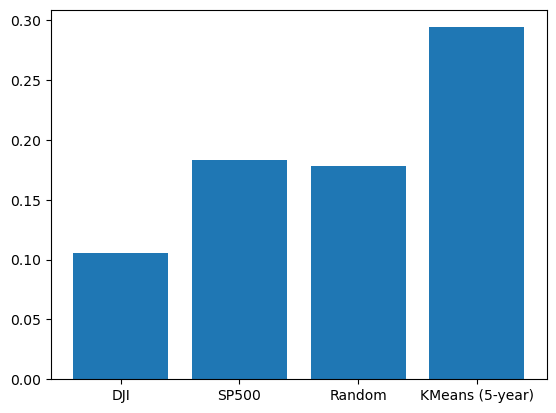

In [13]:
dates = pd.to_datetime(kmeans5s_returns.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans5s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (5-year)']])
plt.bar(['DJI', 'SP500', 'Random', 'KMeans (5-year)'], kmeans5s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (5-year)']].mean());

,DJI,SP500,Random,KMeans (5-year)
Sell Date,,,,
2019-12-30,0.106005,0.162305,0.140583,0.136964
2020-12-28,0.010114,0.030030,0.029885,0.078408
2021-12-31,0.086928,0.117038,0.103209,0.063794
2022-12-30,-0.029764,-0.041853,-0.038713,-0.039675
2023-12-29,0.070132,0.092691,0.078217,0.074781


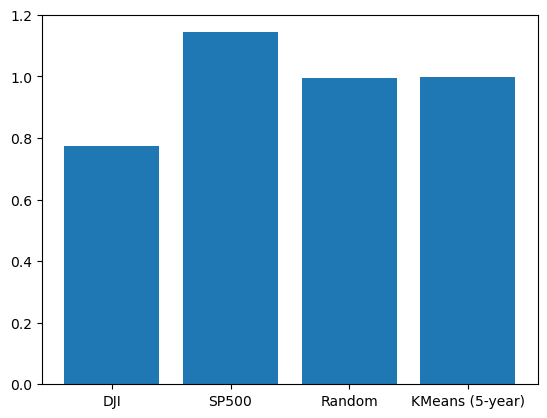

In [14]:
kmeans5s_sharpe = kmeans5s[['Sell', 'DJI_Sharpe', 'SP500_Sharpe', 'Random_Sharpe', 'sharpe']]
kmeans5s_sharpe.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (5-year)']
kmeans5s_sharpe = kmeans5s_sharpe.set_index('Sell Date')
dates = pd.to_datetime(kmeans5s_sharpe.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans5s_sharpe.loc[eoy])
plt.bar(kmeans5s_sharpe.columns, kmeans5s_sharpe.loc[eoy].mean() * np.sqrt(252));

,DJI,SP500,Random,KMeans (5-year)
Sell Date,,,,
2019-12-30,0.129066,0.208522,0.186352,0.202662
2020-12-28,0.011203,0.032057,0.033048,0.085383
2021-12-31,0.119913,0.161321,0.150364,0.086338
2022-12-30,-0.045356,-0.068767,-0.062744,-0.062666
2023-12-29,0.113058,0.145020,0.124768,0.115693


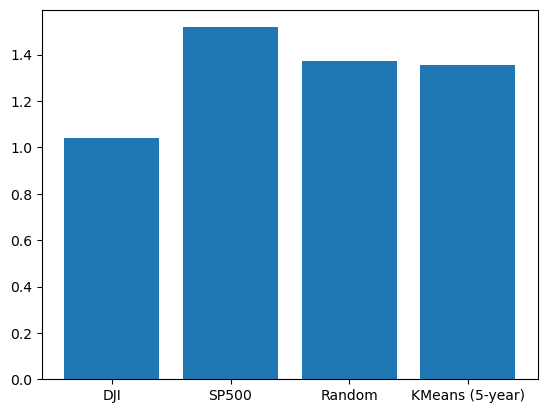

In [15]:
kmeans5s_sortino = kmeans5s[['Sell', 'DJI_Sortino', 'SP500_Sortino', 'Random_Sortino', 'sortino']]
kmeans5s_sortino.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (5-year)']
kmeans5s_sortino = kmeans5s_sortino.set_index('Sell Date')
dates = pd.to_datetime(kmeans5s_sortino.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans5s_sortino.loc[eoy])
plt.bar(kmeans5s_sortino.columns, kmeans5s_sortino.loc[eoy].mean() * np.sqrt(252));

### KMeans (7:1)

In [16]:
kmeans7s = pd.read_csv('data/avg_scaled_7-1.csv')
kmeans7s['rank'] = kmeans7s.groupby('Sell')['sharpe'].rank(method='max', ascending=False)
kmeans7s = kmeans7s[kmeans7s['rank'] == 1].drop(['rank'], axis = 1)

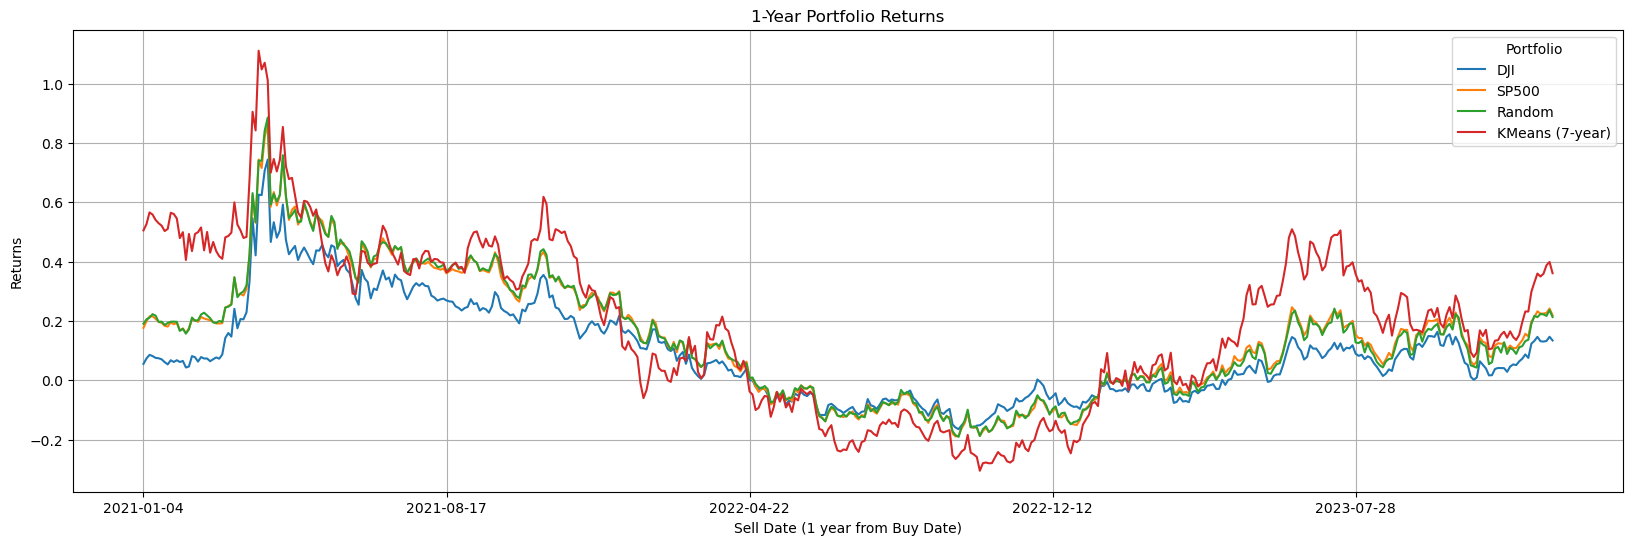

In [17]:
kmeans7s_returns = kmeans7s[['Sell', 'DJI_Return', 'SP500_Return', 'Random_Return', 'return']]
kmeans7s_returns.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (7-year)']
kmeans7s_returns = kmeans7s_returns.set_index('Sell Date')
ig, ax = plt.subplots(figsize=(20, 6))

kmeans7s_returns.plot(ax=ax)

ax.set_title('1-Year Portfolio Returns')
ax.set_xlabel('Sell Date (1 year from Buy Date)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

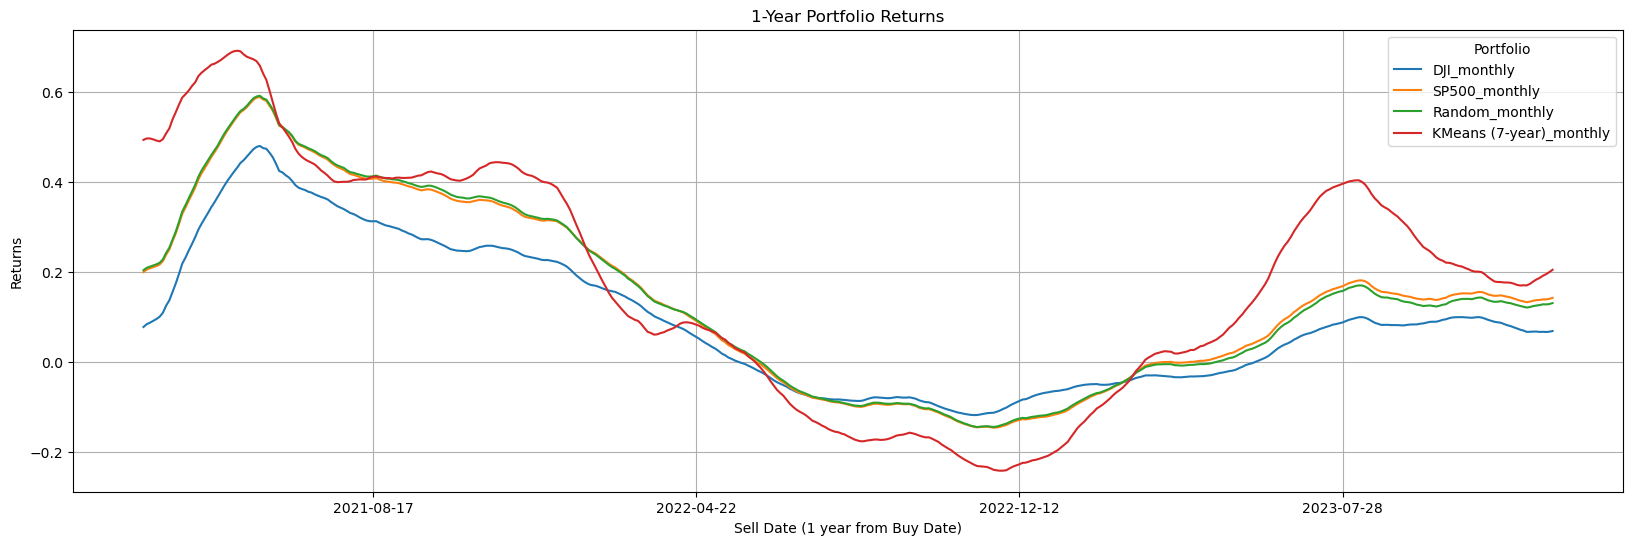

In [18]:
cols = ['DJI', 'SP500', 'Random', 'KMeans (7-year)']
cols_monthly = []
for k in cols:
    colname = f"{k}_monthly"
    kmeans7s_returns[colname] = kmeans7s_returns[k].rolling(window=30).mean()
    cols_monthly.append(colname)

fig, ax = plt.subplots(figsize=(20, 6))


kmeans7s_returns[cols_monthly].plot(ax=ax)

ax.set_title('1-Year Portfolio Returns')
ax.set_xlabel('Sell Date (1 year from Buy Date)')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

,DJI,SP500,Random,KMeans (7-year)
Sell Date,,,,
2021-12-31,0.187275,0.288420,0.289460,0.242812
2022-12-30,-0.089313,-0.148165,-0.140454,-0.203254
2023-12-29,0.134516,0.219223,0.213526,0.361156


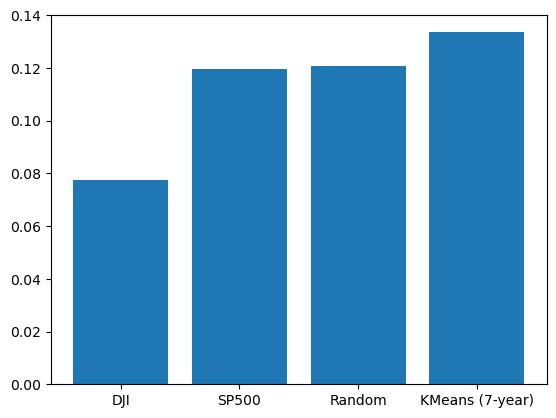

In [19]:
dates = pd.to_datetime(kmeans7s_returns.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans7s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (7-year)']])
plt.bar(['DJI', 'SP500', 'Random', 'KMeans (7-year)'], kmeans7s_returns.loc[eoy][['DJI', 'SP500', 'Random', 'KMeans (7-year)']].mean());

,DJI,SP500,Random,KMeans (7-year)
Sell Date,,,,
2021-12-31,0.086928,0.117038,0.105634,0.066402
2022-12-30,-0.029764,-0.041853,-0.038480,-0.039534
2023-12-29,0.070132,0.092691,0.081106,0.100892


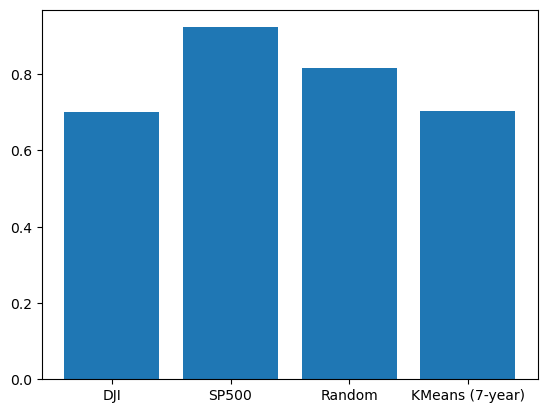

In [20]:
kmeans7s_sharpe = kmeans7s[['Sell', 'DJI_Sharpe', 'SP500_Sharpe', 'Random_Sharpe', 'sharpe']]
kmeans7s_sharpe.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (7-year)']
kmeans7s_sharpe = kmeans7s_sharpe.set_index('Sell Date')
dates = pd.to_datetime(kmeans7s_sharpe.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans7s_sharpe.loc[eoy])
plt.bar(kmeans7s_sharpe.columns, kmeans7s_sharpe.loc[eoy].mean() * np.sqrt(272));

,DJI,SP500,Random,KMeans (7-year)
Sell Date,,,,
2021-12-31,0.119913,0.161321,0.153342,0.091883
2022-12-30,-0.045356,-0.068767,-0.062072,-0.062696
2023-12-29,0.113058,0.145020,0.129627,0.162141


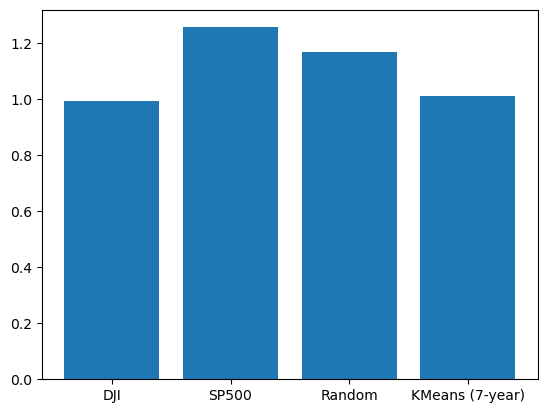

In [21]:
kmeans7s_sortino = kmeans7s[['Sell', 'DJI_Sortino', 'SP500_Sortino', 'Random_Sortino', 'sortino']]
kmeans7s_sortino.columns = ['Sell Date', 'DJI', 'SP500', 'Random', 'KMeans (7-year)']
kmeans7s_sortino = kmeans7s_sortino.set_index('Sell Date')
dates = pd.to_datetime(kmeans7s_sortino.index)
eoy =  dates.to_series().groupby(dates.year).max().astype(str).tolist()
display(kmeans7s_sortino.loc[eoy])
plt.bar(kmeans7s_sortino.columns, kmeans7s_sortino.loc[eoy].mean() * np.sqrt(252));